In [ ]:
import os
exp_num = 1
os.environ["WANDB_API_KEY"] = "00c5bcfd2b2fbe9bce38152923c98635448f8c6f"
EXPERIMENT_NAME = f'MLP_GAN_1:4_{exp_num}'

In [ ]:
os.system('mkdir ../dataset') 
os.system('mkdir ../models')
os.system('wget -O ../dataset/KDDTrain+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt')
os.system('wget -O ../dataset/KDDTest+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt')
os.system('wget -O ../dataset/KDDTrain+_20Percent.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B_20Percent.txt')
os.system('wget -O ../dataset/KDDTest-21.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest-21.txt')
os.system('wget -O ../models/r2l_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/r2l_gen.pt')
os.system('wget -O ../models/u2r_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/u2r_gen.pt')
os.system('wget -O ../models/dos_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/dos_gen.pt')
os.system('wget -O ../models/probe_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/probe_gen.pt')
os.system('wget -O ../models/normal_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/normal_gen.pt')

In [ ]:
os.system('pip install wandb -q')
os.system(f'wandb login {os.environ["WANDB_API_KEY"]}')
import wandb

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
#plt.style.use('grayscale')
from sklearn.metrics import precision_recall_curve,RocCurveDisplay
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn import preprocessing
import time

In [ ]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(f'Using {device} as device')

Using cpu as device


In [ ]:
class Critic(nn.Module):
  def __init__(self, data_dim):
    super(Critic,self).__init__()
    self.disc = nn.Sequential(
        nn.Conv1d(1,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Conv1d(3,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(111, data_dim),
    )

  def forward(self, x):
    return self.disc(x)


class Generator(nn.Module):
  def __init__(self, z_dim, data_dim):
    super(Generator,self).__init__()
    self.gen = nn.Sequential(
        nn.Conv1d(1,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Conv1d(3,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Linear(96, data_dim),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.gen(x)

In [ ]:
def visualize_synthetic_data(generated, original, title):
  generated = generated[np.random.randint(0,len(generated),41)]
  original = original.iloc[np.random.randint(0,len(original),41),:41][:41]

  fig, (original_ax, synthesized_ax) = plt.subplots(1,2,figsize=(12,12))
  original_ax.set_title(f'Original({title})')
  synthesized_ax.set_title(f'Synthetic({title})')
  _ = original_ax.imshow(original)
  _ = synthesized_ax.imshow(generated)

In [ ]:
def generate_data(generator, num_instances, z_dim):
  generator.eval()
  with torch.no_grad():
    out = generator(torch.randn(num_instances, z_dim).view(-1,1,z_dim))
    return out.detach().reshape(-1,41)[:num_instances]

In [ ]:
def create_dataloader(X, y, batch_size):
  if y:
    y = np.array(X['41'])
  else:
    y = torch.ones(size=(X.shape[0],))
  y = torch.tensor(y, dtype=torch.float).to(device)

  X = np.array(X.iloc[:,:-1])
  X = torch.tensor(X, dtype=torch.float).to(device)

  pt_train = TensorDataset(X,y)
  pt_train = DataLoader(pt_train, batch_size=batch_size)
  return pt_train

In [ ]:
def normalize_data(X):
  mms = MinMaxScaler()
  return mms.fit_transform(X)

In [ ]:
def visualize_train_loss(loss_1, labels, epochs, loss_2 = None):
  plt.figure(figsize=(10,4))
  plt.plot(loss_1, linewidth=2)
  if loss_2:
    plt.plot(loss_2, linewidth=2)
  plt.legend(labels)
  plt.ylabel("loss")
  _ = plt.xlabel(f"epochs ({epochs})")

## Preprocessing

In [ ]:
df=pd.read_csv('../dataset/KDDTrain+.txt', header=None)
df2=pd.read_csv('../dataset/KDDTest+.txt', header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df.columns = [str(i) for i in range(0, len(df.columns))]
df2.columns = [str(i) for i in range(0, len(df2.columns))]

In [ ]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)
df2.fillna(0, inplace=True)

In [ ]:
# Peak on dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df.shape

(125973, 43)

In [ ]:
# Peak on the dataset
df.drop('42',axis=1, inplace=True)
df2.drop('42',axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
sub_classes = df.iloc[:,41].value_counts()

In [ ]:
print(sub_classes)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64


In [ ]:
r2l = ['ftp_write','guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient','warezmaster','xlock', 'xsnoop','named',
       'sendmail','snmpgetattack', 'snmpguess','httptunnel']
u2r = ['buffer_overflow', 'loadmodule','perl','ps','rootkit','sqlattack','xterm']
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop','pod','mailbomb', 'processtable','udpstorm', 'worm','apache2']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan','saint','mscan']
normal = ['normal']

In [ ]:
pd.set_option('display.max_rows', None) # or 1000.
train_1 = df['1'].value_counts()
train_1.rename('Train', inplace=True)
test_1 = df2['1'].value_counts()
test_1.rename('Test', inplace=True)
cnct = pd.concat([train_1, test_1], axis = 1)
cnct

,Train,Test
tcp,102689,18880
udp,14993,2621
icmp,8291,1043


In [ ]:
train_2 = df['2'].value_counts()
train_2.rename('Train', inplace=True)
test_2 = df2['2'].value_counts()
test_2.rename('Test', inplace=True)
cnct = pd.concat([train_2, test_2], axis = 1)
cnct

,Train,Test
http,40338,7853.0
private,21853,4774.0
domain_u,9043,894.0
smtp,7313,934.0
ftp_data,6860,851.0
eco_i,4586,262.0
other,4359,838.0
ecr_i,3077,752.0
telnet,2353,1626.0
finger,1767,136.0


In [ ]:
train_3 = df['3'].value_counts()
train_3.rename('Train', inplace=True)
test_3 = df2['3'].value_counts()
test_3.rename('Test', inplace=True)
cnct = pd.concat([train_3, test_3], axis = 1)
cnct

,Train,Test
SF,74945,14875
S0,34851,2013
REJ,11233,3850
RSTR,2421,669
RSTO,1562,773
S1,365,21
SH,271,73
S2,127,15
RSTOS0,103,2
S3,49,249


In [ ]:
df_X = df.drop('41', axis=1)
le = LabelEncoder()
for i in df_X:
  if df_X[i].dtype=='object':
    le.fit(df_X[i])
    df_X[i] = le.transform(df_X[i])
    df2[i] = le.transform(df2[i])
df.iloc[:,:40] = df_X

In [ ]:
df.iloc[:,:40] = normalize_data(df.iloc[:,:40])
df2.iloc[:,:40] = normalize_data(df2.iloc[:,:40])

In [ ]:
u2r_attacks = df[df['41'].apply(lambda x: x in u2r)].copy()
r2l_attacks = df[df['41'].apply(lambda x: x in r2l)].copy()
dos_attacks = df[df['41'].apply(lambda x: x in dos)].copy()
probe_attacks = df[df['41'].apply(lambda x: x in probe)].copy()
normal_traffic = df[df['41'].apply(lambda x: x in normal)].copy()

df['41'] = df['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

df2['41'] = df2['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

### Training set value counts

In [ ]:
df['41'].value_counts()

normal       67343
malicious    58630
Name: 41, dtype: int64

### Testing set value counts

In [ ]:
print(df2['41'].value_counts())

malicious    12833
normal        9711
Name: 41, dtype: int64


In [ ]:
#In case of multi-class classification
#df_Y = le.fit(df['41']).transform(df['41'])
#df.iloc[:,41] = df_Y
#df_Y = le.transform(df2['41'])
#df2.iloc[:,41] = df_Y

#In case of binary classification
df.iloc[:,41] = df['41'].map(lambda x: 0 if x=='normal' else 1)
df2.iloc[:,41] = df2['41'].map(lambda x: 0 if x=='normal' else 1)

X_train = df.drop(['41'],axis=1)
y_train = df['41']

X_test = df2.drop(['41'],axis=1)
y_test = df2['41']
X_test = torch.tensor(np.array(X_test), dtype=torch.float, device=device)

**Creating TensorDatasets**

In [ ]:
r2l_dataset = create_dataloader(r2l_attacks, None, batch_size = 64)
u2r_dataset = create_dataloader(u2r_attacks, None, batch_size = 64)
dos_dataset = create_dataloader(dos_attacks, None, batch_size = 64)
probe_dataset = create_dataloader(probe_attacks, None, batch_size = 64)
normal_dataset = create_dataloader(normal_traffic, None, batch_size = 64)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
r2l_generator = Generator(100,41)
r2l_generator.load_state_dict(torch.load('../models/r2l_gen.pt'))
u2r_generator = Generator(100,41)
u2r_generator.load_state_dict(torch.load('../models/u2r_gen.pt'))
dos_generator = Generator(100,41)
dos_generator.load_state_dict(torch.load('../models/dos_gen.pt'))
probe_generator = Generator(100,41)
probe_generator.load_state_dict(torch.load('../models/probe_gen.pt'))
normal_generator = Generator(100,41)
normal_generator.load_state_dict(torch.load('../models/normal_gen.pt'))

<All keys matched successfully>

In [ ]:
r2l_attacks.shape, probe_attacks.shape

((995, 42), (11656, 42))

In [ ]:
sample_space = 60000
total_attacks = sample_space * 1
r2l_req = 0 if sample_space <= r2l_attacks.shape[0] else sample_space - r2l_attacks.shape[0]
probe_req = 0 if sample_space <= probe_attacks.shape[0] else sample_space - probe_attacks.shape[0]
dos_req = 0 if sample_space <= dos_attacks.shape[0] else sample_space - dos_attacks.shape[0]
u2r_req = 0 if sample_space <= u2r_attacks.shape[0] else sample_space - u2r_attacks.shape[0]
normal_req = 0 if total_attacks <= normal_traffic.shape[0] else total_attacks - normal_traffic.shape[0]

In [ ]:
r2l_generated = generate_data(generator=r2l_generator, num_instances=r2l_req, z_dim=100)
u2r_generated = generate_data(generator=u2r_generator, num_instances=u2r_req, z_dim=100)
dos_generated = generate_data(generator=dos_generator, num_instances=dos_req, z_dim=100)
probe_generated = generate_data(generator=probe_generator, num_instances=probe_req, z_dim=100)
normal_generated = generate_data(generator=normal_generator, num_instances=normal_req, z_dim=100)

In [ ]:
r2l_generated.shape

torch.Size([59005, 41])

In [ ]:
r2l_generated = pd.DataFrame(r2l_generated.detach().numpy())
u2r_generated = pd.DataFrame(u2r_generated.detach().numpy())
dos_generated = pd.DataFrame(dos_generated.detach().numpy())
probe_generated = pd.DataFrame(probe_generated.detach().numpy())
normal_generated = pd.DataFrame(normal_generated.detach().numpy())

In [ ]:
r2l_attacks.columns = [i for i in range(df.shape[1])]
r2l_attacks = r2l_attacks.append(r2l_generated)
u2r_attacks.columns = [i for i in range(df.shape[1])]
u2r_attacks = u2r_attacks.append(u2r_generated)
dos_attacks.columns = [i for i in range(df.shape[1])]
dos_attacks = dos_attacks.append(dos_generated)[:sample_space]
probe_attacks.columns = [i for i in range(df.shape[1])]
probe_attacks = probe_attacks.append(probe_generated)
normal_traffic.columns = [i for i in range(df.shape[1])]
normal_traffic = normal_traffic.append(normal_generated)[:sample_space]

In [ ]:
def create_stratified_dataset(x, sample_space):
  dataset = []

  x[0].iloc[:,41] = 1
  x[1].iloc[:,41] = 1
  x[2].iloc[:,41] = 1
  x[3].iloc[:,41] = 1

  x[0] = x[0].to_numpy()
  x[1] = x[1].to_numpy()
  x[2] = x[2].to_numpy()
  x[3] = x[3].to_numpy()
  x[4] = x[4].to_numpy()

  for i in range(sample_space):
    dataset.append(x[0][i])
    dataset.append(x[1][i])
    dataset.append(x[2][i])
    dataset.append(x[3][i])
    dataset.append(x[4][i])
    
  return pd.DataFrame(dataset, columns=[str(i) for i in range(42)])

In [ ]:
dataset = pd.concat([r2l_attacks, u2r_attacks, dos_attacks, probe_attacks], axis=0)
dataset.columns = [str(i) for i in range(len(dataset.columns))]
normal_traffic.columns = [str(i) for i in range(len(dataset.columns))]
dataset.iloc[:,41] = 1
normal_traffic.iloc[:,41] = 0
dataset.reset_index(inplace=True, drop=True)
dataset = pd.concat([dataset, normal_traffic])
dataset = dataset.sample(frac=1)
#dataset = create_stratified_dataset([r2l_attacks, u2r_attacks, dos_attacks, probe_attacks, normal_traffic], sample_space)

In [ ]:
r2l_attacks.shape,u2r_attacks.shape,dos_attacks.shape,probe_attacks.shape, normal_traffic.shape

((60000, 42), (60000, 42), (60000, 42), (60000, 42), (60000, 42))

In [ ]:
X = dataset.drop('41', axis=1).to_numpy()
y = dataset['41']

In [ ]:
print(f'{X.shape} final size') 
print(f'Following are the label counts\n{y.value_counts()}')

(300000, 41) final size
Following are the label counts
1    240000
0     60000
Name: 41, dtype: int64


In [ ]:
pt_x_train = torch.tensor(X, dtype=torch.float).to(device)
y = nn.functional.one_hot(torch.tensor(y.to_numpy(dtype='int')))
pt_y_train = y.float().to(device)
tensor_dataset = TensorDataset(pt_x_train, pt_y_train)

In [ ]:
pt_x_train.shape, pt_y_train.shape

(torch.Size([300000, 41]), torch.Size([300000, 2]))

## **MLP**



In [ ]:
class MLP(nn.Module):
  data_dim = 41
  def __init__(self, hidden_size):
      super(MLP, self).__init__()
      self.mlp = nn.Sequential(
          nn.Linear(self.data_dim, hidden_size),
          nn.ReLU(),
          nn.BatchNorm1d(hidden_size)
      )

      self.clf = nn.Sequential(
          nn.Linear(hidden_size,2),
          nn.Sigmoid()
      )

  def forward(self, x):
      features = self.mlp(x)
      return self.clf(features)

In [ ]:
def validation_accuracy(model, X, y):
  model.eval()
  with torch.no_grad():
    lr_probs = model(X).detach().squeeze()
  preds = torch.argmax(lr_probs, dim=1).cpu()
  acc = accuracy_score(y, preds)
  model.train()
  return acc

In [ ]:
hidden_sizes = [16, 32, 64, 80]
batch_sizes = [64, 128, 256]
epochs_ = [50, 75, 100]
learning_rates = [1e-3, 1e-2, 1e-1]

In [ ]:
start_time = time.time()

In [ ]:
grid_scores = []
iters = 1
#Creating a Grid Search
for hidden_size in hidden_sizes:
  for epochs in epochs_:
    for lr in learning_rates:
      for batch_size in batch_sizes:
        #Model init
        pt_train = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
        mlp = MLP(hidden_size).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(mlp.parameters(), lr = lr)
        
        #Training Loop
        run = wandb.init(entity='ahsen', project='nids', 
                         name=f'{EXPERIMENT_NAME}_{iters}', 
                         group=EXPERIMENT_NAME, reinit=True,
                         )
        wandb.config["lr"] = lr
        wandb.config["batch_size"] = batch_size
        wandb.config["epochs"] = epochs
        wandb.config["hidden_size"] = hidden_size
        print('========================================================')
        print(f"Hidden Size:{hidden_size}\tEpochs:{epochs}\tLR:{lr}\tBatch Size:{batch_size}")
        num_epochs = epochs
        losses = []
        for epoch in range(num_epochs):
            for instance, y in pt_train:
                output = mlp(instance)
                loss = criterion(output, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses.append(loss.item())
            acc = validation_accuracy(mlp, X_test, y_test)
            wandb.log({'loss':loss.item()})
            print('------------------------------------------------')
            print(f'Epoch:{epoch+1}  \tLoss:{loss.item():.4f}\t Acc: {acc:.4f}')

        print("*************************************************")
        print(f'Final Score for (H:{hidden_size}, Ep:{epochs}, LR:{lr}, B:{batch_size})')
        print(f'Acc: {acc:.4f}')
        #Save scores
        obj = {
          "name":f'{EXPERIMENT_NAME}_{iters}',
          "config":{
            "learning_rate": lr,
            "epochs": epochs,
            "batch_size": batch_size,
            "acc": acc,
            "hidden_size": hidden_size
            },
          "weights": mlp.state_dict(),
          "losses": losses
        }
        wandb.log({"acc" : acc})
        run.finish()
        grid_scores.append(obj)
        elapsed = time.time() - start_time
        print(f'Time Elapsed:\t{elapsed:.0f} seconds')
        iters = iters + 1

In [ ]:
highest = 0
for i,score in enumerate(grid_scores):
  if score['config']['acc'] > grid_scores[highest]['config']['acc']:
    highest = i

In [ ]:
end_time = time.time()
print("=====================================")
print(f'Total time taken: {int(end_time-start_time)} seconds')
print(f'Best scores with:\t{grid_scores[highest]["name"]}')
print(f'{grid_scores[highest]["config"]}')

Total time taken: 37752 seconds
Best scores with:	MLP_GAN_1:4_1_78
{'learning_rate': 0.01, 'epochs': 100, 'batch_size': 256, 'acc': 0.8296220723917672, 'hidden_size': 64}


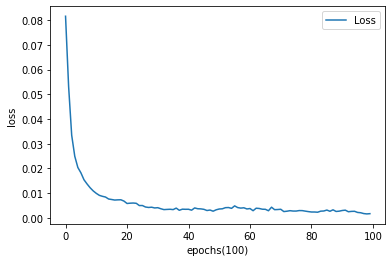

In [ ]:
losses = grid_scores[highest]['losses']
num_epochs = grid_scores[highest]['config']['epochs']
plt.plot(losses)
plt.xlabel(f"epochs({num_epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [ ]:
mlp = MLP(grid_scores[highest]['config']['hidden_size']).to(device)
mlp.load_state_dict(grid_scores[highest]['weights'])
mlp.eval()
with torch.no_grad():
  lr_probs = mlp(X_test).detach().squeeze()
probs = torch.max(lr_probs, dim=1)
idxs, scores = probs.indices, probs.values
probs = [scores[i].item() if idxs[i]==1 else 1-scores[i].item() for i in range(len(idxs))]
preds = torch.argmax(lr_probs, dim=1).cpu()
lr_probs = torch.max(lr_probs, dim=1).values
probs = np.array(probs)

In [ ]:
suspicious = probs[(probs>0.4) & (probs<0.5)].shape[0]

In [ ]:
print(f'{suspicious} packets are suspicious')

306 packets are suspicious


In [ ]:
cm = confusion_matrix(y_test, preds)
tn=cm[1][1] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[0][0] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+"\nRecall: "+str(format(recall,'.4f')))

Test accuracy is:0.8296
Precision: 0.7258
Recall: 0.9714


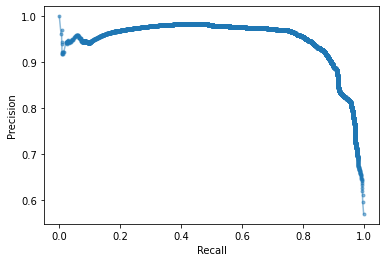

F1:	 82.838%
AUC:	 94.765%
Accuracy:82.962%


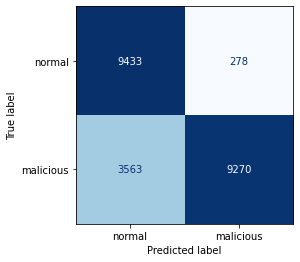

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, probs)
lr_f1, lr_auc = f1_score(y_test, preds), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==0]) / len(y_test)
acc = accuracy_score(y_test, preds)
plt.plot(lr_recall, lr_precision, marker='.', alpha=0.5)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the plot
plt.show()
_ = plt.rc('legend', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['normal', 'malicious'])
disp.plot(cmap="Blues", colorbar = False)
print(f"F1:\t {lr_f1*100:.3f}%")
print(f"AUC:\t {lr_auc*100:.3f}%")
print(f"Accuracy:{acc*100:.3f}%")

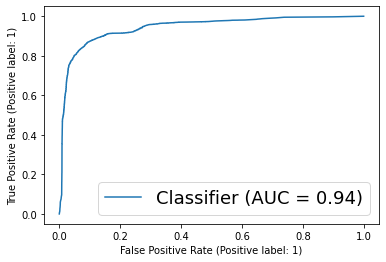

In [ ]:
_ = RocCurveDisplay.from_predictions(y_test,probs)

In [ ]:
wandb.finish()

In [ ]:
torch.save(mlp.state_dict(), 'mlp_1:4.pt')